# Problem Statement
In an increasingly digitalized world, there has been a decreasing focus on soft skills. In many aspects this is great, however in the aspect of Customer Service, dealing with unpleasant staff when ordering your morning coffee may not be the greatest way to start the day. It may not be the intention of the staff to be rude, however if we could use emotion recognition to detect the general satisfaction level of the customer, we can use this to train staff that directly interact with customers to improve the customer's experience. This way, despite the shift towards digitalizing every possible aspect of daily life, we can still preserve the element of human touch. 

There are several measures of Customer Satisfaction. Some explicit examples  would be using the Net Promoter Score or requesting for feedback in various ways such as via customer app surveys.

An implicit method that we intend to use to measure Customer Satisfaction is to use Facial Expression Recognition as a gauge of the customer's experience, specifically at cafes where there still exists interactions with customers. While this does not quantify the customer's total experience as it does not take into account separate factors such as the customer's sentiment towards the cafe's food and drinks, it can classify their expressions based on their interaction with the serving staff.

# Executive Summary
For the scope of this project, we will be using 35,000 labelled images containing 7 different expressions from the FER2013 dataset from this [Kaggle Competition]( https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data). The images are 48x48 pixel grayscale images of faces.

We will make necessary adjustments to classes upon exploration. 

For the modelling portion, we will be building our own custom Convolutional Neural Network (CNN), as well as making use of Transfer Learning strategies to fine-tune pre-trained models such as VGGFace (Base Model & Tuned Model) and EfficientNetB0 (Base Model & Tuned Model). These models will be evaluated on validation loss and accuracy on the test set, as well as on unseen data.

# EDA

## Imports for EDA

In [70]:
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
from random import sample
import matplotlib.pyplot as plt
from keras.preprocessing import image

sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [73]:
from google.colab import drive

local = False
if local:
    working_dir = 'data/'
else:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    working_dir = '/content/drive/MyDrive/Colab Notebooks/'

## Reading in raw CSV:

In [74]:
df = pd.read_csv('./fer2013/fer2013.csv')

In [75]:
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [76]:
df.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

## Removing Usage Column:
This dataset comes with our data pre-split into Training, PublicTest & PrivateTest in the `Usage` column.

We will drop this column and later perform our own Train/Test/Split.

In [77]:
df.drop(columns='Usage', inplace=True)

In [104]:
df.head(20)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,1,231 212 156 164 174 138 161 173 182 200 106 38...
3,3,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,5,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5,1,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6,3,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7,2,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8,2,85 84 90 121 101 102 133 153 153 169 177 189 1...
9,1,255 254 255 254 254 179 122 107 95 124 149 150...


In [79]:
df.shape

(35887, 2)

## Duplicates:
### Checking for duplicates:

In [80]:
df.loc[df.duplicated(subset='pixels')].sort_values(by='pixels')

,emotion,pixels
13402,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
13988,5,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
22927,6,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
22198,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
7629,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...
32774,5,98 99 98 78 70 70 50 60 67 82 88 92 98 127 110...
23367,6,99 100 100 102 90 35 30 32 30 30 28 33 46 66 8...
19803,3,99 115 111 92 104 111 108 120 121 119 112 125 ...
6821,2,99 95 101 114 124 129 128 127 128 124 123 125 ...


### Checking duplicate labels:

First, we check the 0 pixel maps. We can see that many of these 0 pixel maps have been labelled differently.

We want to check if the entire row of pixels are zeros, so we use a sum function:

In [81]:
#checking for other lines that have the same `pixels` as index 13402:
df[df['pixels'] == df['pixels'][13402]]

,emotion,pixels
6458,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
7629,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
10423,4,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
11286,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
13148,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
13402,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
13988,5,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
15894,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
22198,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
22927,6,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [82]:
total_sum=0
zero_pixels = df[df['pixels'] == df['pixels'][13402]]['pixels']
for row in zero_pixels:
    total_sum+=sum(np.array(row.split(" "), int))
    print(total_sum)

0
0
0
0
0
0
0
0
0
0
0
0


All of `total_sum` is 0 so these rows are just empty space, which we will drop later.

Now we will randomly check the duplicated values of a few rows in `pixels` that contain nonzeros. If emotions are classified as the same across duplicated values, we'll drop them.

In [83]:
df[df['pixels'] == df['pixels'][23367]]

,emotion,pixels
13140,6,99 100 100 102 90 35 30 32 30 30 28 33 46 66 8...
23367,6,99 100 100 102 90 35 30 32 30 30 28 33 46 66 8...


In [84]:
df[df['pixels'] == df['pixels'][19803]]

,emotion,pixels
14724,3,99 115 111 92 104 111 108 120 121 119 112 125 ...
19803,3,99 115 111 92 104 111 108 120 121 119 112 125 ...


In [85]:
df[df['pixels'] == df['pixels'][32774]]

,emotion,pixels
23202,5,98 99 98 78 70 70 50 60 67 82 88 92 98 127 110...
32774,5,98 99 98 78 70 70 50 60 67 82 88 92 98 127 110...


There seems to be no difference in classification - thus, we will drop all duplicates.

In [86]:
df.drop_duplicates(subset=['pixels'], inplace=True)
df.shape

(34034, 2)

## Visualization
Per Kaggle, the following numbers correspond to the below emotions - 

0: Angry |
1: Disgust |
2: Fear |
3: Happy |
4: Sad |
5: Surprise |
6: Neutral 

For visualization purposes, let's rename the emotion classes to include the emotion names:

In [87]:
df['emotion'].replace([0, 1, 2, 3, 4, 5, 6],
                      ['0: angry', '1: disgust', 
                       '2: fear', '3: happy',
                       '4: sad', '5: surprise','6: neutral'], 
                     inplace=True)

In [88]:
df.head()

,emotion,pixels
0,0: angry,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0: angry,151 150 147 155 148 133 111 140 170 174 182 15...
2,2: fear,231 212 156 164 174 138 161 173 182 200 106 38...
3,4: sad,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6: neutral,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


Let's first take a look at the distribution of image classes in our dataset below; we can see that there is a lack of images that are classified as disgust based on the countplot below:

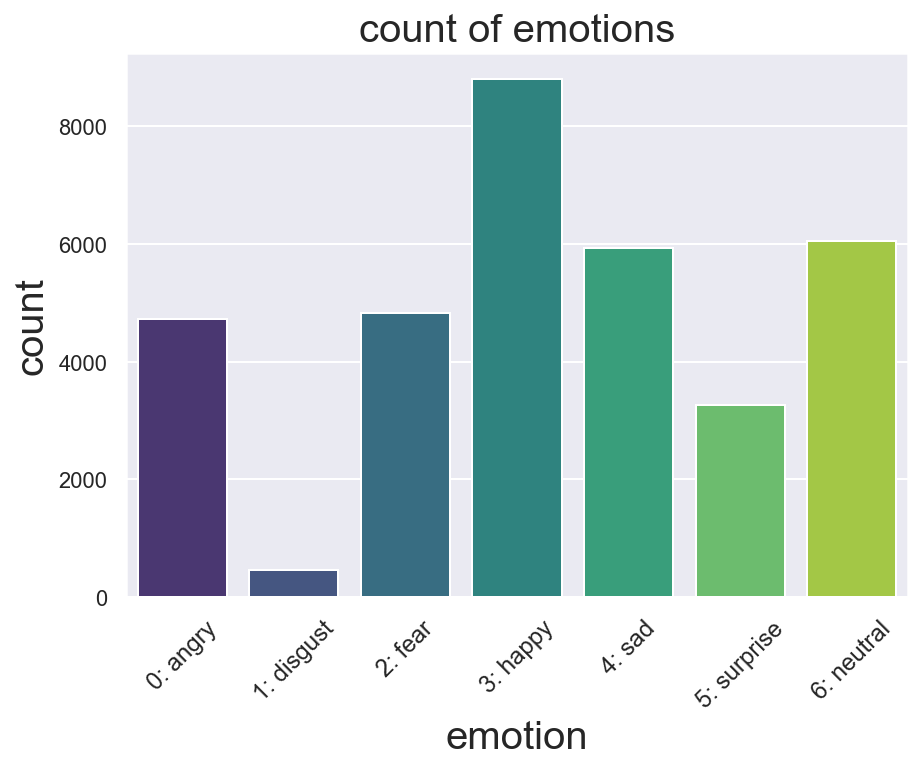

In [89]:
sns.set(rc={'figure.figsize':(7,5),
           'axes.labelsize': 20})

sns.countplot(x='emotion', 
              data=df.sort_values(by='emotion'),
              palette='viridis')
plt.xticks(fontsize=12, rotation=45);       
plt.title('count of emotions', size=20);
plt.savefig('./images/countofemotions.png', 
            transparent=True, 
            bbox_inches='tight')

Let's take a look at a few images from each class.

In [92]:
emotions

array(['0: angry', '2: fear', '4: sad', '6: neutral', '3: happy',
       '5: surprise', '1: disgust'], dtype=object)

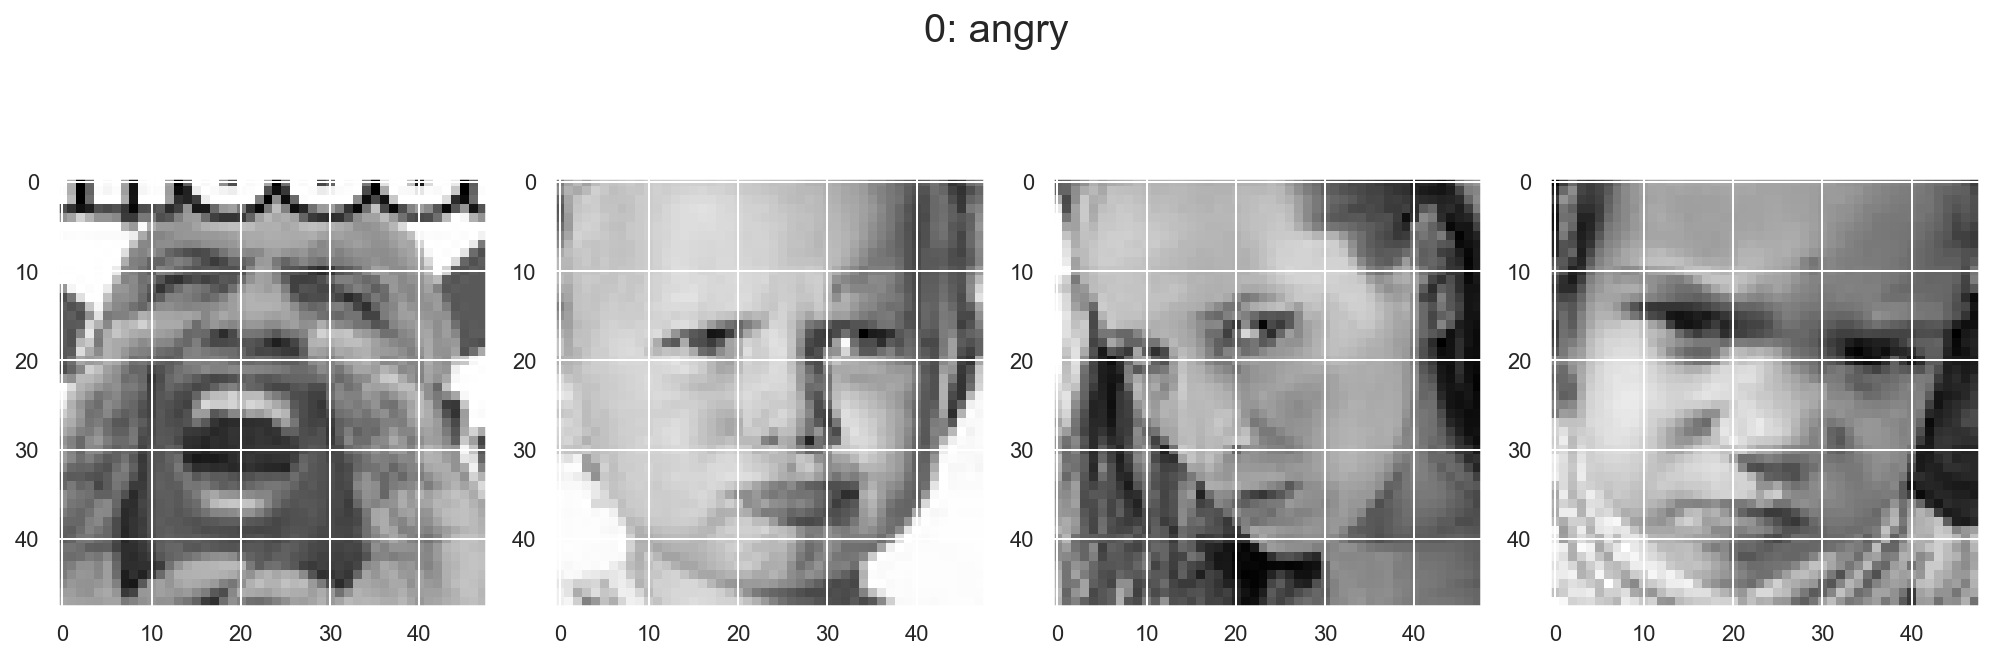

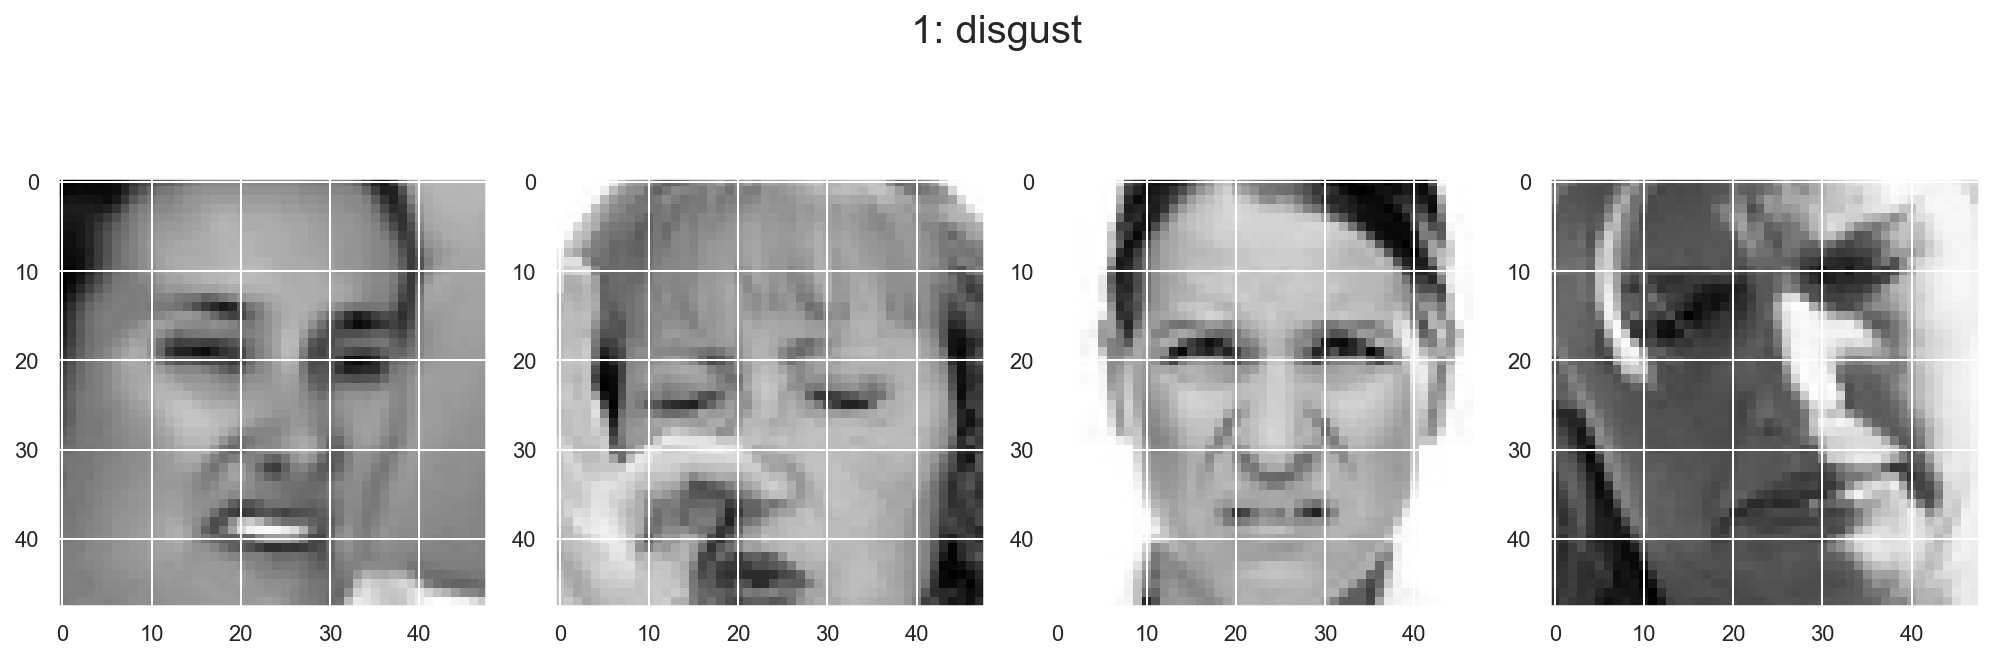

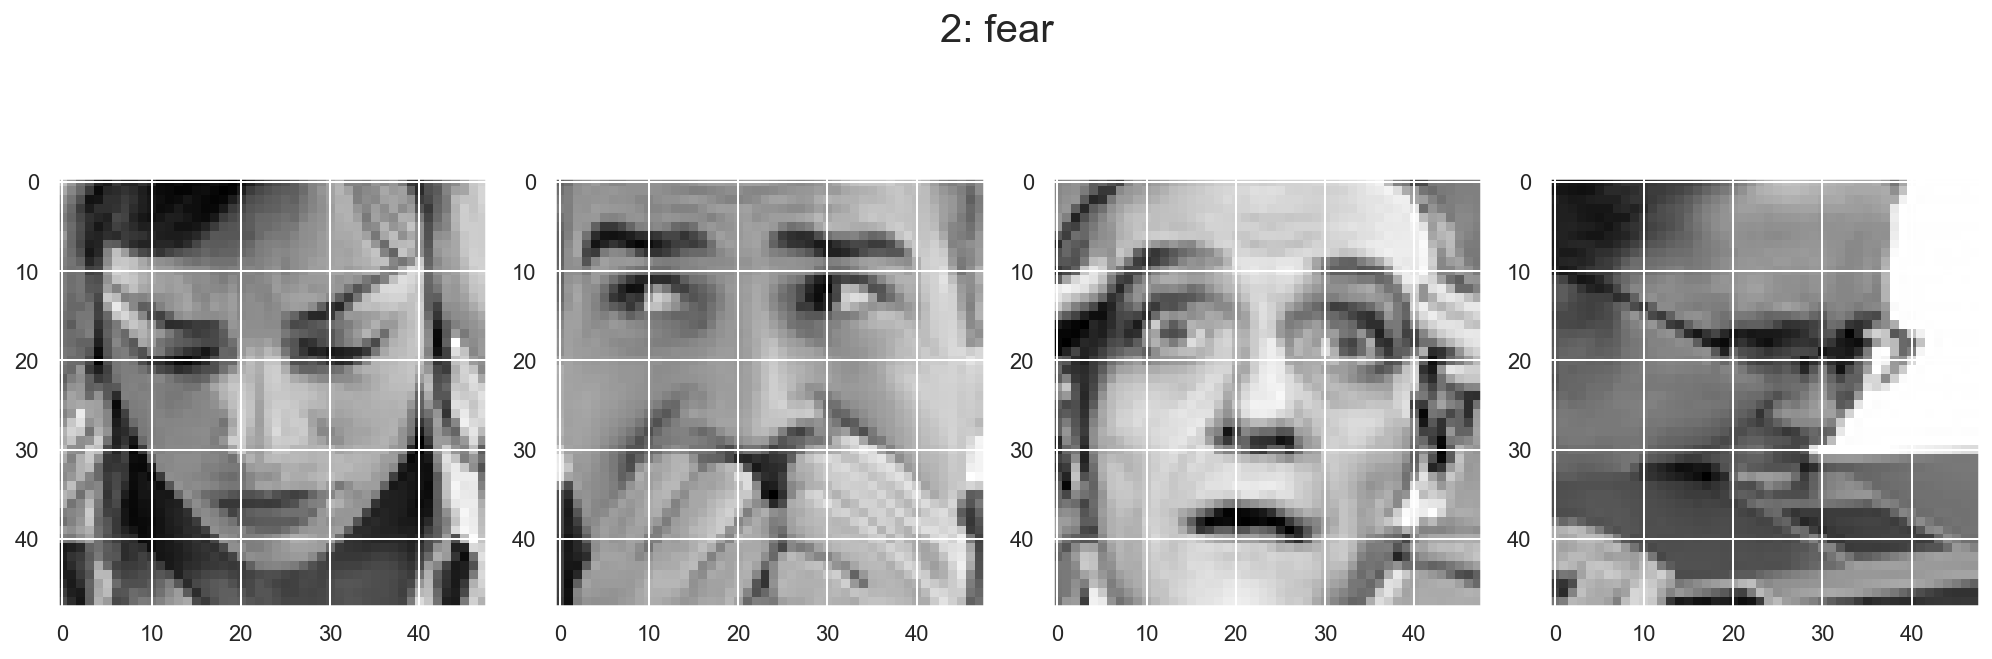

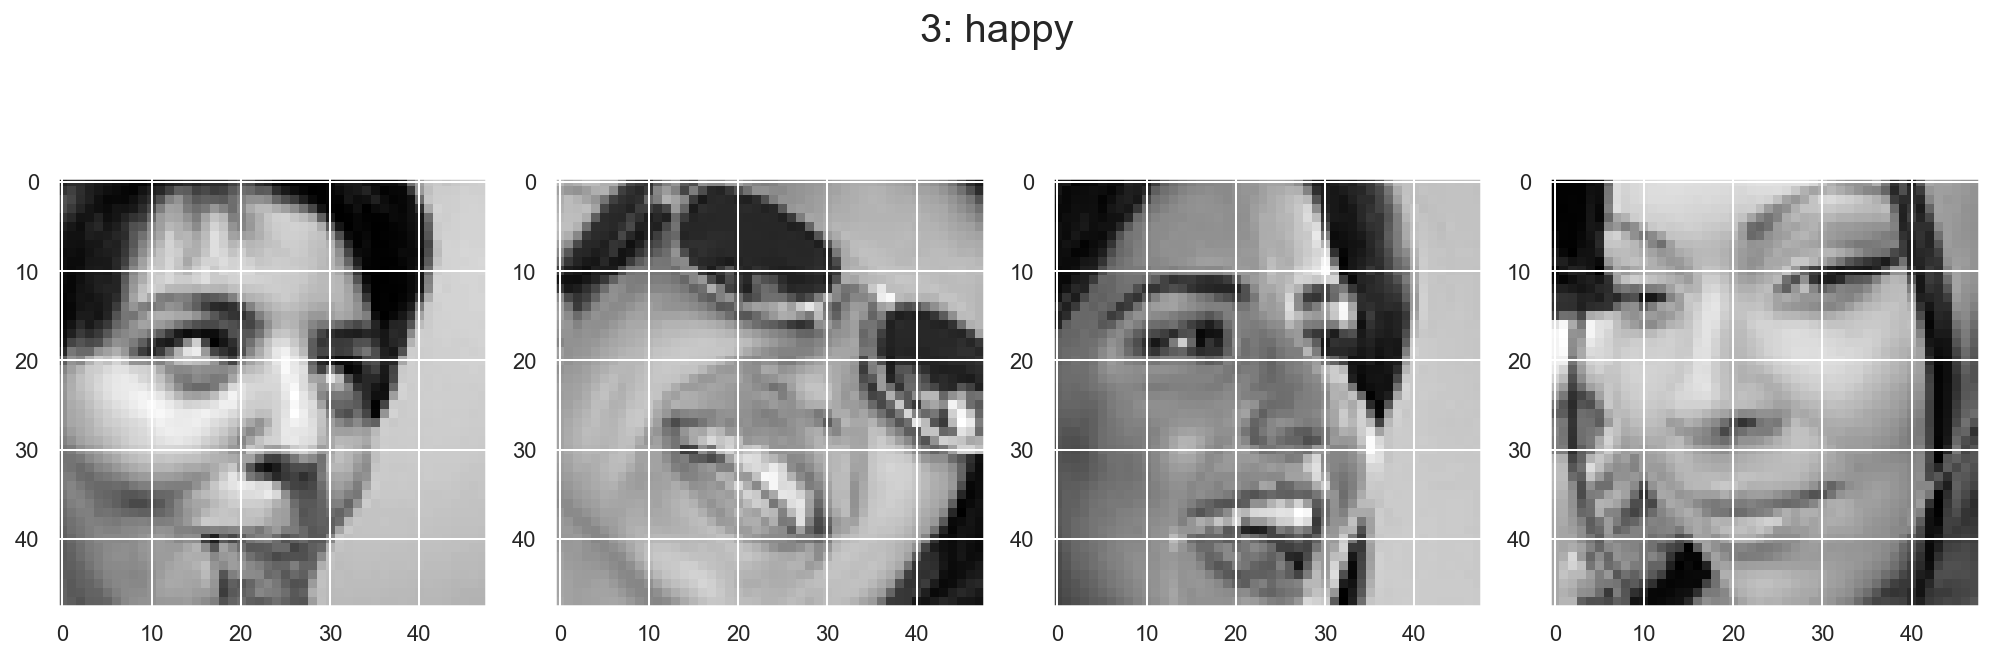

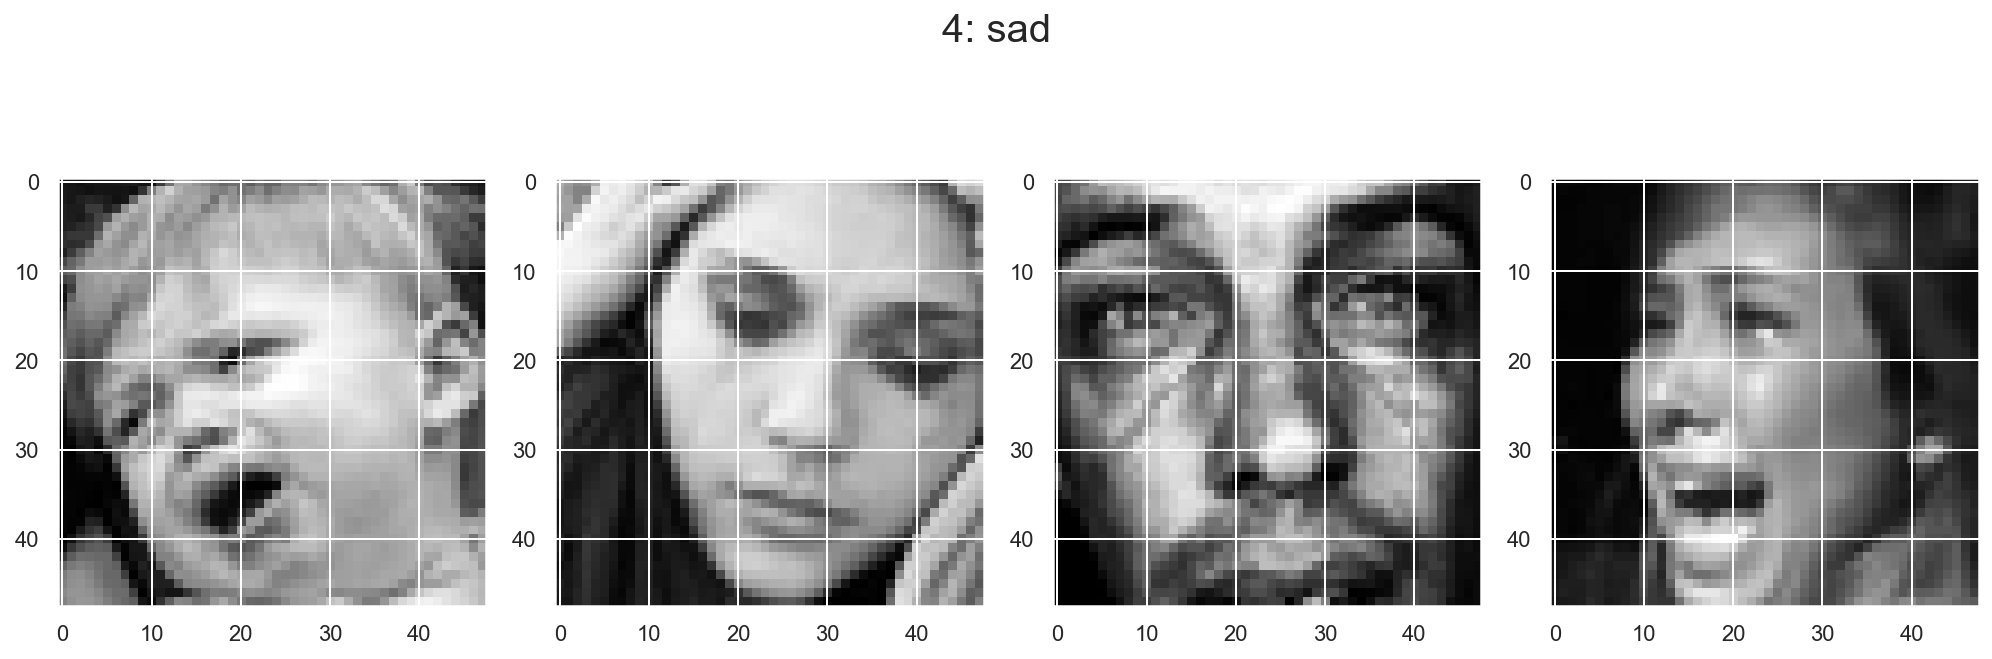

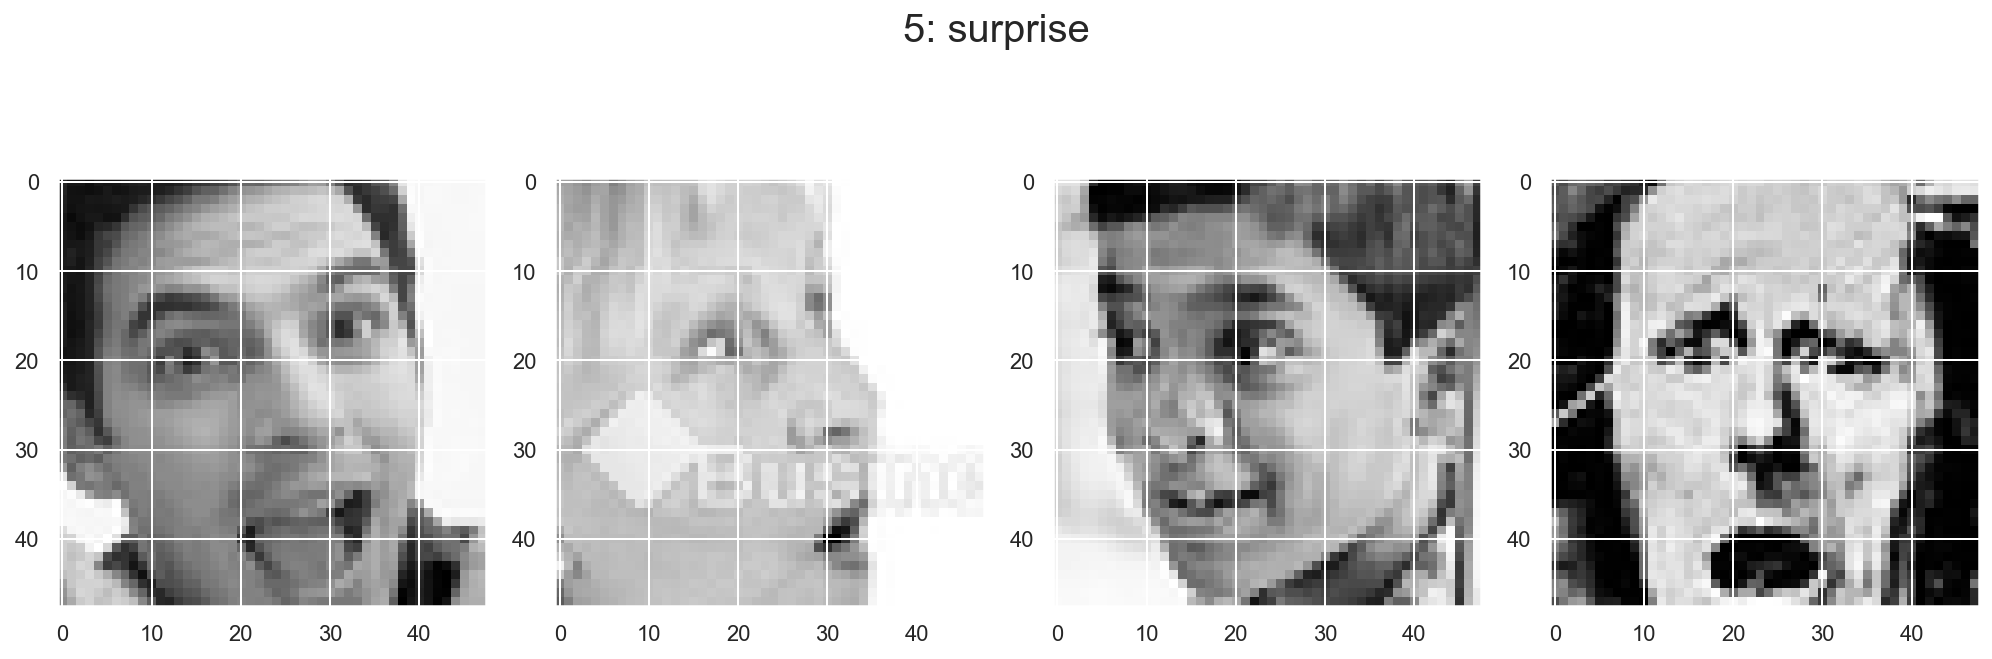

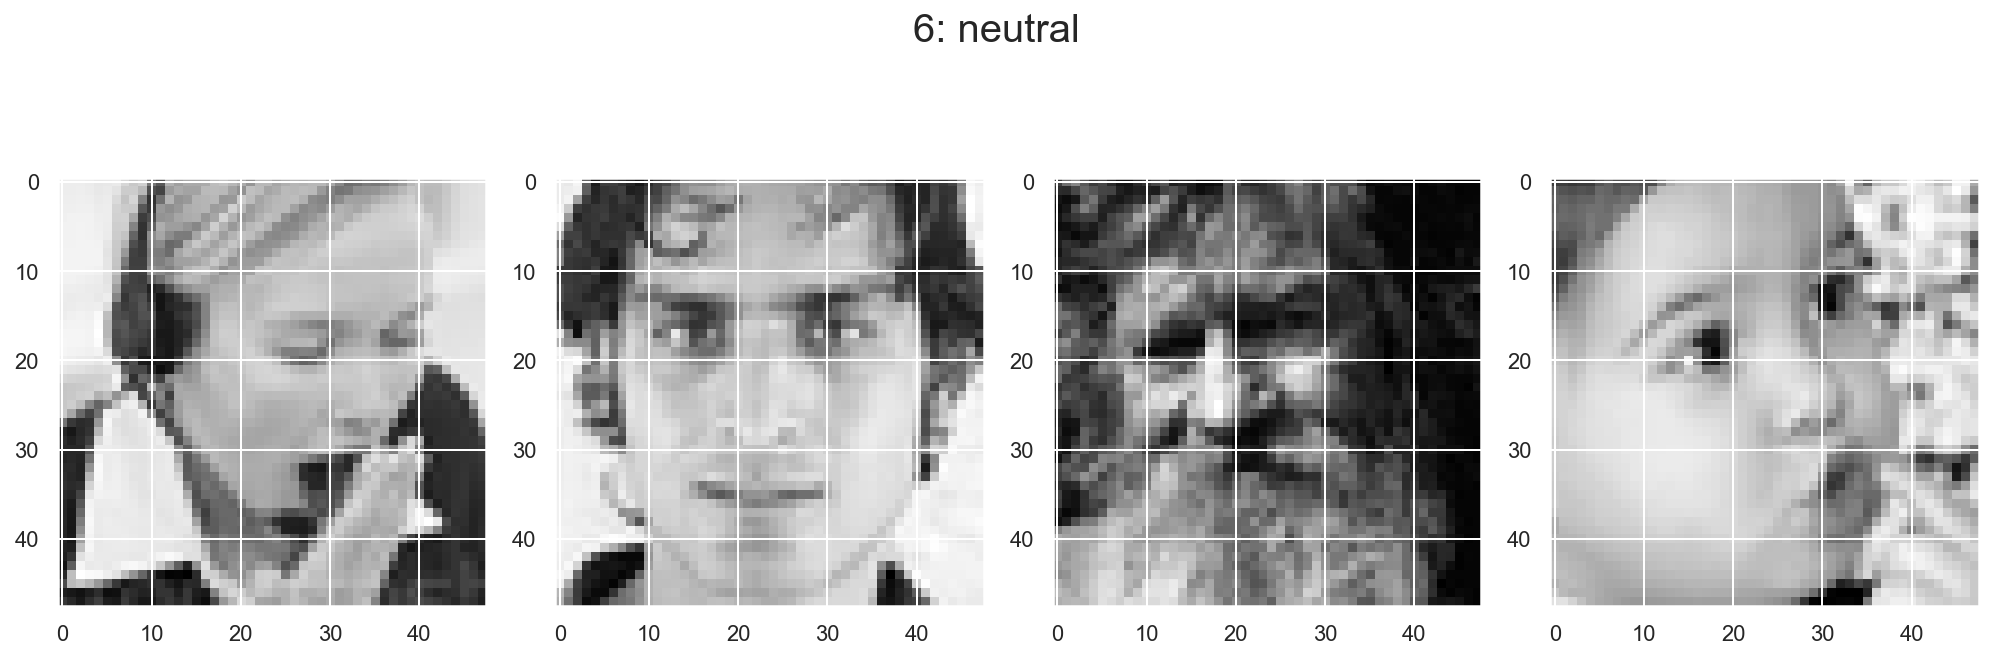

In [93]:
emotions = df['emotion'].unique()

for i, emotion in enumerate(sorted(emotions)):
    fig, ax = plt.subplots(ncols = 4, figsize = (14,5))
    emo_pixels = df[df['emotion'] == emotion]['pixels']
    for j,img in enumerate(random.sample(list(emo_pixels), 4)):
        img = np.array(img.split(' '), 'float32').reshape(48,48)/255
        ax[j].imshow(img, cmap = 'gray')
        fig.suptitle(emotion, fontsize=20)
        fig.tight_layout()

Emotions classified as 1: disgust and 0: anger have similar facial features, and based on the random samples shown above from each category, disgust and anger are difficult to tell apart.

Disgust seems to be not easily distinguishable from anger. Given that we lack a substantial amount of images that are pre-classified as disgust, we will classify disgust images under the category anger.

In [94]:
df['emotion'].replace('1: disgust','0: angry',inplace=True)

Our updated class distribution is as follows:

In [95]:
df['emotion'].value_counts(normalize=True)

3: happy       0.258447
6: neutral     0.177822
4: sad         0.174002
0: angry       0.152406
2: fear        0.141623
5: surprise    0.095698
Name: emotion, dtype: float64

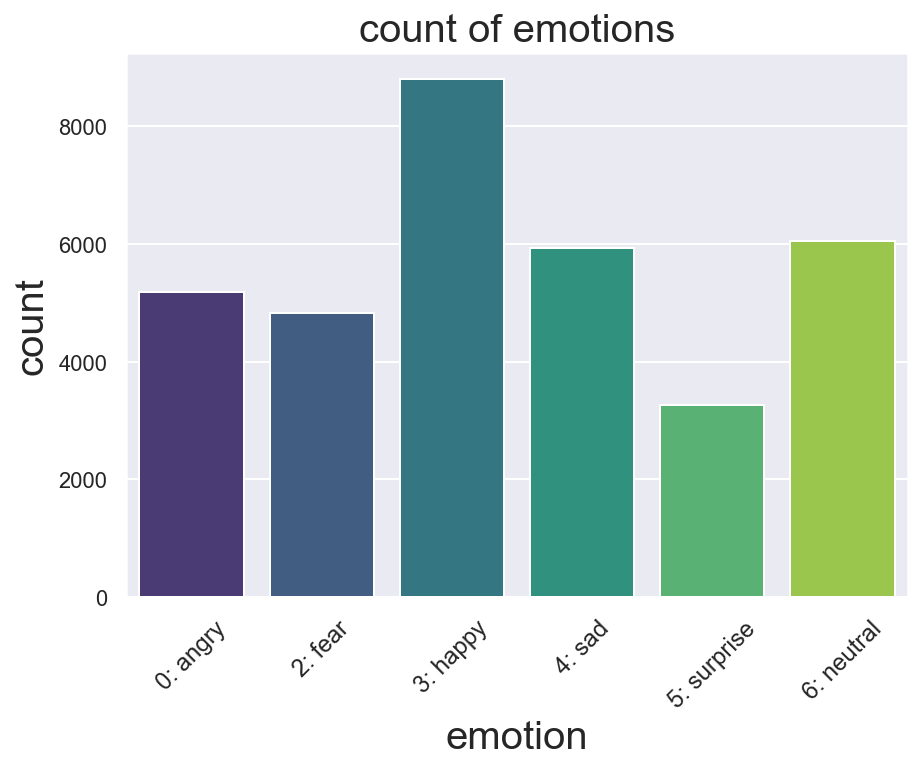

In [96]:
sns.set(rc={'figure.figsize':(7,5),
           'axes.labelsize': 20})

sns.countplot(x='emotion', 
              data=df.sort_values(by='emotion'),
              palette='viridis')
plt.xticks(fontsize=12, rotation=45);       
plt.title('count of emotions', size=20);
plt.savefig('./images/countofemotions.png', 
            transparent=True, 
            bbox_inches='tight')

We will convert these class names back to integers.

In [97]:
df['emotion'].replace(['0: angry','2: fear','3: happy','4: sad','5: surprise','6: neutral'], 
                      [0,1,2,3,4,5],
                     inplace=True)

In [98]:
df.emotion.value_counts()

2    8796
5    6052
3    5922
0    5187
1    4820
4    3257
Name: emotion, dtype: int64

In [99]:
df.dtypes

emotion     int64
pixels     object
dtype: object

We will save a new csv of our cleaned data. However, it is unlikely that this data will be used for modelling, as we will explore the cropping function below.

In [100]:
df.to_csv('fer2013_cleaned.csv', index=False)

### Reading in cleaned csv

In [101]:
cleaned_df = pd.read_csv('fer2013_cleaned.csv')

While manually scanning through some of the images, certain images seemed to not be zoomed in with an aspect that is consistent with other images. An example would be the following - where 

Text(0.5, 1.0, '1')

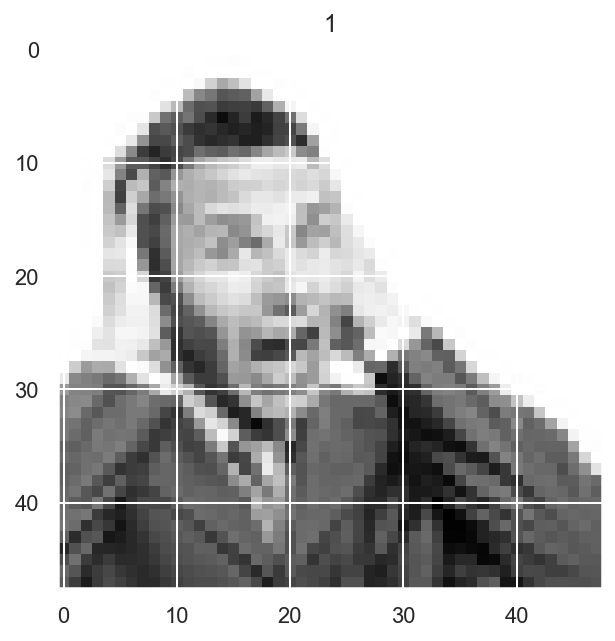

In [103]:
#show(np.array(cleaned_df['pixels'][17].split(' '), 'float32')/255)
plt.imshow((np.array(cleaned_df['pixels'][17].split(' '), 'float32')/255).reshape(48, 48), cmap = 'gray')
plt.title(df['emotion'][17])

In [105]:
np.array(cleaned_df['pixels'][17].split(' '), 'float32')

array([255., 255., 255., ...,  79.,  79.,  83.], dtype=float32)

In [38]:
noface_images = []

def crop_face(pixels, missed_images=[], name=0):
    # cv2 takes in int and a flat image (no channels)
    gray = pixels.reshape(pixels.shape[0],pixels.shape[1]).astype('uint8')
    faceCascade = cv2.CascadeClassifier("./haarcascade_frontalface_alt.xml")
    faces = faceCascade.detectMultiScale(gray,
                                         scaleFactor=1.01,
                                         minNeighbors=3,
                                         minSize=(24, 24)
                                        )
    # If no faces found - just return original
    if (len(faces) == 0):
        missed_images.append(name)
        return pixels
    (x,y,w,h) = faces[0]
    # Focus face
    gray = gray[y:y+h,x:x+w]
    # Add back channel
    gray = gray.reshape((gray.shape[0], gray.shape[1], 1))
    # Reshape back to 48x48
    gray = image.smart_resize(gray, (48,48))
    return gray.astype('float32')


In [39]:
#applying above function
cleaned_df['cropped_pixels'] = cleaned_df.apply(
    lambda row:' '.join(np.array(crop_face(np.array(row['pixels'].split(" ")).reshape(48,48), noface_images), 'str').flatten()), axis=1)


Exporting the cropped function to CSV:

In [40]:
cleaned_df.to_csv('fer2013_cleaned_cropped.csv', index=False)